In [8]:
from pymatreader import read_mat
import numpy as np
import librosa
import eelbrain as eel

In [10]:
X = read_mat(r'./ExJobb/ID1001/PreprocIV_ID1001_mast.mat')

In [695]:
data = np.array(X['ICAcleaned_data_allsess'][0]['trial'])[:,:,256*5:256*38]

In [696]:
attended = ["./ExJobb/Files_Audio/" + X['ICAcleaned_data_allsess'][0]['targetfiles'][i].split('\\')[-1] for i in range(20)]
masker = ["./ExJobb/Files_Audio/" + X['ICAcleaned_data_allsess'][0]['maskerfiles'][i].split('\\')[-1] for i in range(20)]

In [697]:
eeg = np.transpose(data,[0,2,1])

In [698]:
attended

['./ExJobb/Files_Audio/F1_11_Christian_Haugk_siger_farvel_og_tak_til_Pause01.wav',
 './ExJobb/Files_Audio/F1_15_Psykolog_skal_hj_lpe_s_rbare_unge_i_Pause02.wav',
 './ExJobb/Files_Audio/F1_33_Efter_stor_interesse_byder_fire_p_Pause02.wav',
 './ExJobb/Files_Audio/F1_19_En_lind_str_m_igennem_byttehuset_Pause02.wav',
 './ExJobb/Files_Audio/F1_11_Ruth_kan_noget_med_virksomhed_og_Pause02.wav',
 './ExJobb/Files_Audio/M3_43_Foreninger_efterlyser_hj_lp_til_Pause02.wav',
 './ExJobb/Files_Audio/M3_73_Nye_frav_rsregler_viser_mangel_p_Pause02.wav',
 './ExJobb/Files_Audio/M3_45_Lyssignalet_var_skiftet_til_et_reserveprogram_Pause02.wav',
 './ExJobb/Files_Audio/M3_76_Udvalg_har_sat_fokus_p_tilflytteres_Pause02.wav',
 './ExJobb/Files_Audio/M3_82_Tilfredshed_unders_ges_Pause02.wav',
 './ExJobb/Files_Audio/F1_20_Koldinghus_bliver_hjems_gt_igen_n_ste_Pause02.wav',
 './ExJobb/Files_Audio/F1_33_13_anholdt_med_tyvekoster_for_fire_til_Pause02.wav',
 './ExJobb/Files_Audio/F1_16_Der_bl_ses_til_kamp_mod_unges_ry

In [714]:
def load_and_preprocess(filenames):
    speech = []
    #tt = eel.UTS(0,1/64.,2048)
    for fname in filenames:
        sp = eel.load.wav(fname)
        sp = eel.resample(sp,44032)
        sp = sp.envelope()
        sp = eel.resample(sp,64)
        sp = eel.filter_data(sp,2,16)
        sp = (sp-sp.mean('time'))/sp.std('time')
        #sp = sp.sub(time=tt)
        speech.append(sp)
    return eel.combine(speech)

In [715]:
speech_attended = load_and_preprocess(attended)
speech_masker = load_and_preprocess(masker)

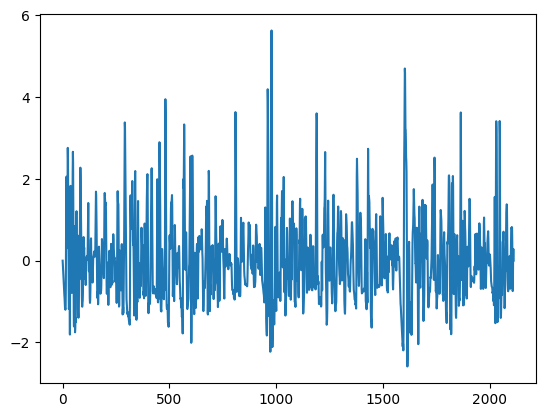

In [716]:
plt.plot(speech_attended[-1].x)

In [717]:
tstep = 1/256
n_times = eeg.shape[1]
time = eel.UTS(0, tstep, n_times)
sensor = eel.Sensor.from_montage('mgh70')[:66]
EEG = eel.NDVar(eeg, (eel.Case,time,sensor), name='EEG', info={'unit': 'µV'})
EEG = eel.resample(EEG,64)
EEG = eel.filter_data(EEG,2,16)
EEG = EEG/EEG.std('time')

In [718]:
from tqdm import tqdm

corr1 = []
corr2 = []
predictions = []

num_trials = 10

for i in tqdm(range(num_trials)):
    c = list(range(0,i)) + list(range(i+1,20))
    #print(c)
    e = EEG.sub(case=c)
    a = speech_attended.sub(case=c)
    #m = speech_masker.sub(case=c)
    res = eel.boosting(a,e,-0.3,0,partitions=8)
    pred = eel.convolve(res.h_scaled,EEG[i])
    predictions.append(pred)
    att = speech_attended[i] 
    mas = speech_masker[i]
    corr1.append(eel.correlation_coefficient(att,pred))
    corr2.append(eel.correlation_coefficient(pred,mas))
    print(corr1[-1])
    print(corr2[-1])



 10%|████████▎                                                                          | 1/10 [00:02<00:20,  2.23s/it]

0.0004877267682453939
-0.05725207577283189


 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.02s/it]

-0.0375958006591557
0.029423319571448323


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:14,  2.13s/it]

0.00972730883741441
0.03776105193179727


 40%|█████████████████████████████████▏                                                 | 4/10 [00:08<00:12,  2.08s/it]

0.014196562762229767
0.004675953513495373


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:10<00:10,  2.04s/it]

0.009235855648417128
0.026454548741520027


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:12<00:08,  2.16s/it]

0.01845805748388734
0.03155085763359954


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:15<00:06,  2.23s/it]

0.007483147002911396
0.03213998923080011


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:17<00:04,  2.16s/it]

-0.0007352449578797317
-0.027746209021080704


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:19<00:02,  2.24s/it]

-0.08929355552171492
0.03838114406073369


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]

-0.024360281819096188
0.016596042390937458


In [704]:
sum(np.array(corr1)>np.array(corr2))/num_trials

0.3

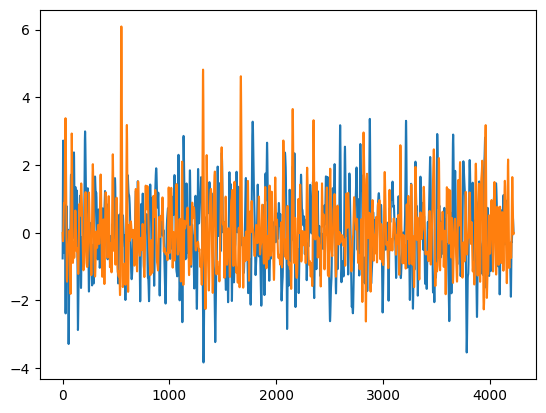

In [663]:
plt.plot(predictions[0].x)
plt.plot(((speech_attended[0]-speech_attended[0].mean('time'))/speech_attended[0].std('time')).x)

{'whiskers': [<matplotlib.lines.Line2D at 0x14cdd4be890>,
 'caps': [<matplotlib.lines.Line2D at 0x14cdd4bedd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14cdd4be5f0>],
 'medians': [<matplotlib.lines.Line2D at 0x14cdd4bf310>],
 'fliers': [<matplotlib.lines.Line2D at 0x14cdd4bf5b0>],
 'means': []}

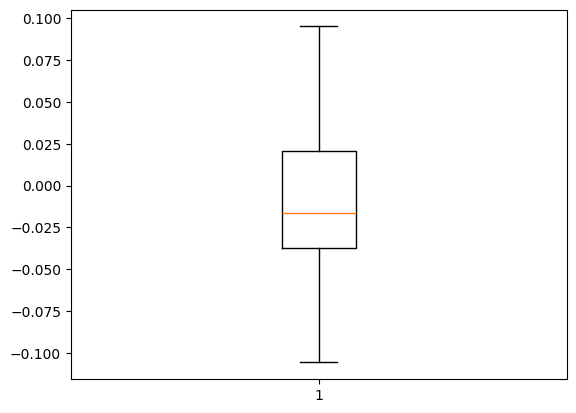

In [659]:
plt.boxplot(corr2)

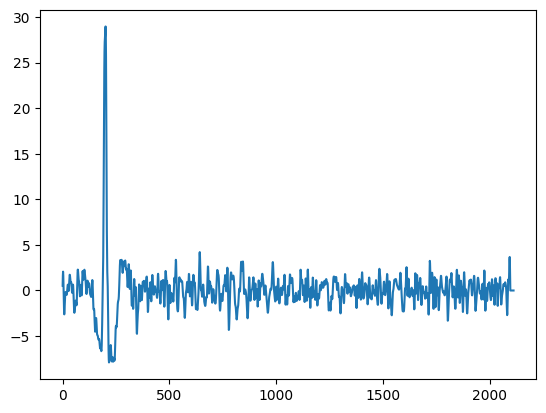

In [592]:
plt.plot(pred.x)

In [664]:
m = ((speech_attended[0]-speech_attended[0].mean('time'))/speech_attended[0].std('time'))

In [665]:
eel.correlation_coefficient(predictions[0],m)

-0.07799295368566585

In [666]:
corr1

[-0.07799295368566585,
 0.01802438504501364,
 -0.0829090746012856,
 -0.018749975902325536,
 0.011051108247951113,
 -0.08192891406247274,
 -0.04349452773333706,
 -0.029637819632611456,
 0.006336207580420008,
 -0.0739361819487715,
 -0.015140721832635116,
 -0.05401738642124601,
 0.08413833137504752,
 -0.05020489972355507,
 -0.0628124813173045,
 0.004788217207074541,
 0.04258561131699693,
 0.049200129534107274,
 0.10694325012572889,
 -0.014348164934856585]